### Initialize

In [1]:
# Define Program Version 
__ver__ = '01'

In [112]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets as widgets
from IPython.display import display
import ipywidgets

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

In [3]:
# Bunch of functions 

def lorentzian_fitfun(f, f0, gamma, amp=1, offset=0):
    return amp * (gamma/2)**2 / ((f-f0)**2 + (gamma/2)**2) + offset

def gaussian(x, x0, sigma, amp, offset=0): return offset + amp*np.exp(- (x-x0)**2 / (2*sigma**2))

def bin_data(xi, yi):
    x = np.unique(xi)
    y = [None] * x.size
    for i in range(x.size): y[i] = yi[xi == x[i]]
    # Return 
    y_mean = np.array([a.mean() for a in y])
    y_err = np.array([np.std(a) / (a.size**0.5) for a in y])
    return (x, y_mean, y_err, y, xi, yi)

# returns rabi in kHz
@np.vectorize
def volt2rabi(volt):
    if volt < 0.1 or volt > 5:
        return 0
    volt = np.log10(volt)
    dbm = 1.5863 +0.2211*volt -0.1022*volt**2 -0.1301*volt**3 -0.0862*volt**4 +0.2323*volt**5 +0.1624*volt**6 -0.1552*volt**7 -0.1206*volt**8
    dbm = 10**dbm
    sqrtpwr = (10**((dbm-30)/10))**(1/2)
    return -0.0332 +0.5832*sqrtpwr -0.0167*sqrtpwr**2

from scipy.optimize import brentq
# Provide rabi in kHz
@np.vectorize
def rabi2volt(rabi):
    if rabi <= volt2rabi(0.1) or rabi >= volt2rabi(5):
        print('outside valid range')
        return 0
    def funSolve(v):
        return rabi - volt2rabi(v)
    return brentq(funSolve, 0.1, 5)
def meshgrid(xLen=10, yLen=10, data=None):
    if data is not None: yLen, xLen = data.shape
    return np.meshgrid(np.arange(xLen, dtype=np.float), np.arange(yLen, dtype=np.float))
def gaussian_2d(x, y, cx=1, cy=1, sx=1, sy=1, amp=1, offset=0, angle=0):
    x, y = x - cx, y - cy
    sx, sy = 2*sx**2, 2*sy**2
    a = angle * np.pi / 180
    xp, yp = x*np.cos(a) + y*np.sin(a), - x*np.sin(a) + y*np.cos(a)
    return offset + amp * np.exp(-xp**2/sx - yp**2/sy)
    
def gaussian_2d_guess(data, x=None, y=None):
    if x is None: x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    t = np.sum(data)
    cx, cy = np.sum(data * x) / t, np.sum(data * y) / t
    sx, sy = (np.sum(data * (x-cx)**2) / t)**(1/2), (np.sum(data * (y-cy)**2) / t)**(1/2)
    return (cx, cy, sx, sy, data[int(cy), int(cx)], np.mean(data)/5, 0.0)
    
def fit_gaussian_2d(data, guess=None, plot=False):
    if guess is None: guess = gaussian_2d_guess(data)
    fr = tp.optimize.surface_fit(data, fun=gaussian_2d, guess=guess, show=plot)
    return fr
def gaussian_2d_integral(data, nsigma, fr=None, ideal=False, plot=False, guess=None, return_mask=False):
    if fr is None: fr = fit_gaussian_2d(data, guess=guess)
    # Generate the fitted data
    x, y = meshgrid(data=data)
    fit_data = gaussian_2d(x, y, *fr)
    amp = 1 if len(fr) <= 4 else fr[4]
    offset = 0 if len(fr) <= 5 else fr[5]
    # Ideal case
    if ideal:
        return np.sum(fit_data - offset)
    # Data case
    threshhold = np.exp(- nsigma**2/2) * amp + offset
    mask = fit_data >= threshhold
    # Plot
    if plot:
        plt.figure()
        plt.imshow(data)
        fit_data[~mask] = 0
        plt.imshow(mask, alpha=0.2, cmap='gray')
    
    # Mask return
    if return_mask:
        return mask
    
    return np.sum(data[mask])

''' 
Copy image names from clipboard and get parameters 
df : if you want to add on to the older df
init : initialize and return empty df
var : list of strings (variable names) that you want to retrive from database
x_var : a string (variable name), available as df.x
image_func : either tp.Image or tp.Hybrid_Image
using : 0=TopA only, 1=TopB only, 2=All Images
'''
def get_from_clipboard(df=None, init=False, var=None, x_var=None, image_func=tp.Image, using=2, display=False):
    # If initializing, then return empty dataframe
    if init: return pd.DataFrame(columns=['name','image'])
    
    # If df is None, make an empty one
    if df is None: 
        df = pd.DataFrame(columns=['name','image'])
    
    # Get the copied image names
    pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
    
    # Filter for using 0:TopA only, 1:TopB only, 2:all
    if using==0:
        pasted_filtered = [p for p in pasted if p[-1]=='A']
    elif using==1:
        pasted_filtered = [p for p in pasted if p[-1]=='B']
    else:
        pasted_filtered = [p for p in pasted]
    
    # Add it to df if not already in there
    names = df.name.tolist()
    for n in tqdm(pasted_filtered, desc='Loading'):
        if n not in names:
            df.loc[df.shape[0]] = n
            df.image[df.shape[0]-1] = image_func(name=n)
    
    # sort in time
    df.sort_values('name', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Get Parameters
    try: bec1db.refresh()
    except: pass
    df['shot'] = np.linspace(0,df.shape[0]/2-0.5,df.shape[0])
    if x_var is not None:
        df['x'] = bec1db.image_query(df.name.tolist(), [x_var])[x_var]
    if type(var) is str:
        df[var] = bec1db.image_query(df.name.tolist(), [var])[var]
    elif type(var) is list:
        _ = bec1db.image_query(df.name.tolist(), var)
        for n in var:
            df[n] = _[n]
    
    # Print Information
    if display:
        print('Pasted Sample : ', pasted[0:2])  
        print('Newly added images       : {}'.format(df.shape[0]- len(names)))
        print('Total number of images   : {}'.format(df.shape[0]))
    
    # return
    return df


def get_roi(data, center=[0,0], width=100, height=100):
    center = (data.shape[1]//2 + center[0], data.shape[0]//2 + center[1])
    return tp.imagedata.get_cropi(data, center=center, width=width, height=height)

def atom_num_filter(df_, keep = 0.15, offset = 0.0, plot=True):
    # Prepare
    if plot: fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    if plot: ax[0].plot(df_['shot'], df_['total_atoms']/1e6,'.-', label='All')
    shapes = [df_.shape]
    
    # Filter
    median_numbers = np.median(df_.total_atoms)
    offset += 1
    using = (df_.total_atoms.values > median_numbers*(offset-keep)) & (df_.total_atoms.values <= median_numbers*(offset+keep))
    bad = df_[~using] 
    df_ = df_[using]
    df_.reset_index(inplace=True, drop=True)
    shapes.append(df_.shape)
    if plot: ax[0].plot(bad['shot'], bad['total_atoms']/1e6, 'rx', label='Atom Num Filter')
    if plot: ax[0].axhline(median_numbers/1e6, linestyle='--', color='k', alpha=0.5)

    if plot: 
        # Plot
        median_numbers = np.median(df_.total_atoms)
        ax[1].plot(df_['shot'], df_['total_atoms']/median_numbers,'o-')
        ax[1].axhline(1, linestyle='--', color='k', alpha=0.5)

        ax[0].legend()
        ax[0].set(title = 'Atom number stability', xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [M]')
        ax[1].set(title = 'Median Atom Num {:.2f} M'.format(median_numbers/1e6), xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [median]')
        plt.tight_layout()

        # Relevant Information
        print('''
        Total Loaded Images {}
        Atom Num Filter     {}
        Removed Images      {}
        '''.format(shapes[0][0], shapes[1][0], shapes[0][0]-shapes[1][0]))
    
    return using

def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))

def mesh_for_2d_plot(x, y, z):
    x1 = np.concatenate([ [2*x[0] - x[1]], x])
    x2 = np.concatenate([x, [2*x[-1] - x[-2]]])
    x = np.mean([x1, x2], axis=0)

    y1 = np.concatenate([ [2*y[0] - y[1]], y])
    y2 = np.concatenate([y, [2*y[-1] - y[-2]]])
    y = np.mean([y1, y2], axis=0)
    
    return (x, y, z)

def fourier_transform(curve, k):
    return np.array([np.trapz(curve.y * np.exp(-1j * ki * curve.x) , curve.x) for ki in k])


In [4]:
# Useful snippets 

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=1000, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )



In [87]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.9):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.35, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N

# Special Functions
def hybrid_total_atoms(kT, mu, trapf=23.35, cross_section=np.pi*(58e-6)**2):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    n_0 = UFG.density(kT, mu)
    z_max = 0
    while True:
        z_max += 50e-6
        if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
    z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
    n = UFG.density(kT, mu - u_* z**2)
    N = np.trapz(n, z) * cross_section
    return N

# In Situ Density Modulation

In [6]:
# Some Fitting functions 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x

In [9]:
# Desplay widgets to select various parameters 

# All the variables to load 
var = ['ExpansionTime','SideGreenEvap','WaitBox',
       'IREvap','HeatTime','ShakeTime','ShakeWait', 'HeatCycles',
       'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
       'SeqMode']

fontsize = 15

# Saving and Loading widgets 
WID_SaveAnalyzedDataBtn = widgets.Button( description='Save Data', button_style='success', )
WID_Folder = widgets.Text( value='AnalyzedData', placeholder='Type Folder to store data', description='Save Folder :')
WID_DatasetType = widgets.Text( value='InsituShakingVsFreq', placeholder='Type Dataset Type/Information', description='Dataset Type :',)
WID_DatasetDate = widgets.Text( value='06_22_2017', placeholder='Type Dataset Date, E.x. 06_15_2017', description='Dataset Date :',)
WID_DatasetName = widgets.Text( value='DS3', placeholder='Type Dataset Name, E.x. DS1', description='Dataset Name :',)

# Select a Particular x_variable
WID_x_var = widgets.ToggleButtons(description='x variable = = > ', 
            options=['ShakeWait', 'ShakingCycles', 'BoxShakeFreq', 'BoxShakeAmp', 'HeatCycles'])
display(WID_x_var)

# Select a Particular x_variable
WID_using_image = widgets.ToggleButtons(description='Image Selection = = > ', 
            options=['A', 'B', 'Both'])
display(WID_using_image)

# Select a Particular X_Label for the plots 
WID_xlabel = widgets.ToggleButtons(description='xlabel for plots = > ', 
            options=['Waittime (ms)', 'Shaking Cycles', 'Shaking Frequency (Hz)', 'Shaking Amplitude (Cicero Volts)', 'Heating Cycles'])
display(WID_xlabel)

# Reduced Plots and Info for Faster Processing 
WID_info = widgets.Checkbox( value=True, description='Show all info plots',)
display(WID_info)

# Additional WID used later 
WID_atoms_keep = widgets.FloatSlider(value=0.07, min=0.01, max=0.4, step=0.01,
                description='Atom Num Selection:', readout=True, readout_format='.2f',
                layout=widgets.Layout(width='50%'), )

WID_height = widgets.IntSlider(value=181, min=105, max=219, step=2,
             description='Height:', readout=True, layout=widgets.Layout(width='50%'), )

WID_width = widgets.IntSlider(value=75, min=15, max=177, step=2,
             description='Width:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_x = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center X:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_y = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center Y:', readout=True, layout=widgets.Layout(width='50%'), )

WID_clim_dN = widgets.FloatSlider(value=0.15, min=0.01, max=0.50, step=0.001,
                description='clim for dN:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

WID_clim_dN_N = widgets.FloatSlider(value=0.15, min=0.01, max=0.5, step=0.001,
                description='clim for dN/N:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

In [2149]:
# ONLY ONCE -- Initialize empty dataframe and select options 
df_all = get_from_clipboard(init=True)

## Load Data from Images

In [2150]:
# Import from Clipboard 
x_var = WID_x_var.value
using = 0 if WID_using_image.value == 'A' else 1 if WID_using_image.value == 'B' else 2
info = WID_info.value
df_all = get_from_clipboard(df=df_all, init=False, var=var, x_var=x_var, image_func=tp.Hybrid_Image, using=using, display=info)

# Keep only right Seq Mode 
df_all = df_all[(df_all['SeqMode'] == 16) | (df_all['SeqMode'] == 11)]
df_all.reset_index(drop=True, inplace=True)
if WID_info.value:
    df_all.head(5) 


Updating the local database...
Done
Pasted Sample :  ['08-07-2017_23_49_59_TopA', '08-07-2017_23_49_59_TopB']
Newly added images       : 289
Total number of images   : 289


08-07-2017_18_10_42_TopA
100.0


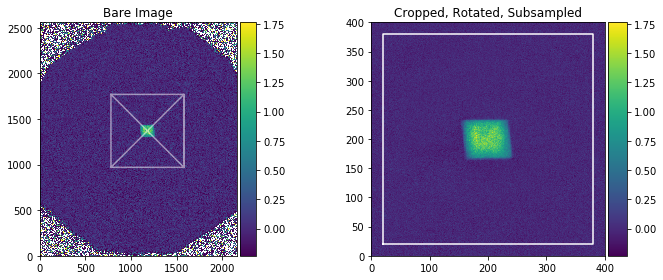

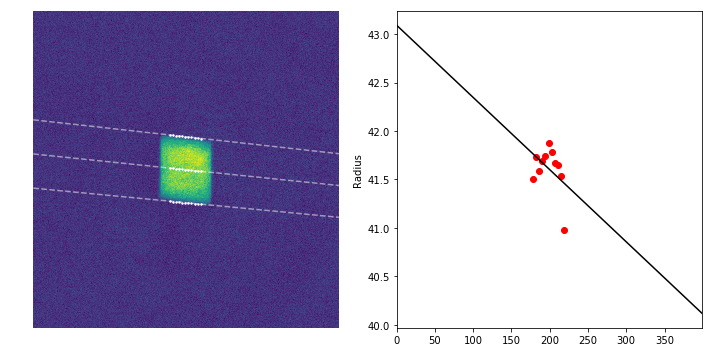

In [2151]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1181, center_y = 1370, width=800, height=800, fudge=1.75, subsample=2, 
                  xsec_extension='linear', xsec_slice_width=4, xsec_fit_range=1.0, radial_selection=0.5,)}

# Apply settings
for i, r in df_all.iterrows():
    r.image.set(**settings)
    
# Tests
if WID_info.value: 
    test = 0
    print(df_all.image.iloc[test].name)
    df_all.image.iloc[test].plot_crop()
    print(df_all.x.iloc[test])
    plt.show()
    fig, ax = plt.subplots(ncols=2, figsize=[10, 5])
    df_all.image.iloc[test].xsec.infoplot(axs=ax)
    plt.tight_layout()

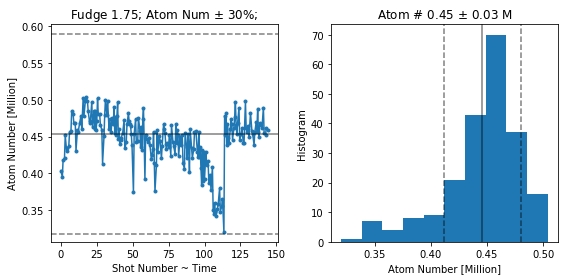

In [2152]:
# Atom Number Filter 

# Parameters 
display(WID_atoms_keep)
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image, desc='Atoms')]
using = atom_num_filter(df_all, keep=WID_atoms_keep.value, offset=0.0, plot=False)
df = df_all[using]

def makeplot_atomnum_time(ax, df_all=df_all, using=using):
    ax.plot(df_all.shot, df_all.total_atoms/1e6, 'C0.-', 
            df_all[~using].shot, df_all[~using].total_atoms/1e6, 'rx')
    median_atom_num = np.median(df_all.total_atoms) / 1e6
    ax.axhline(median_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 + WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 - WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Shot Number ~ Time', ylabel='Atom Number [Million]', 
              title='Fudge {}; Atom Num $\pm$ {:.0f}%;'.format(df.image.iloc[0].fudge, WID_atoms_keep.value*100))

def makeplot_atomnum_hist(ax, df=df):
    ax.hist(df.total_atoms/1e6)
    mean_atom_num = np.mean(df.total_atoms)/1e6
    std_atom_num = np.std(df.total_atoms)/1e6
    ax.axvline(mean_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axvline(mean_atom_num + std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.axvline(mean_atom_num - std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Atom Number [Million]', ylabel='Histogram', title='Atom # {:.2f} $\pm$ {:.2f} M'.format(mean_atom_num, std_atom_num))

fig, ax = plt.subplots(ncols=2, figsize=[8, 4])
makeplot_atomnum_time(ax[0], df_all, using)
makeplot_atomnum_hist(ax[1], df)
plt.tight_layout()

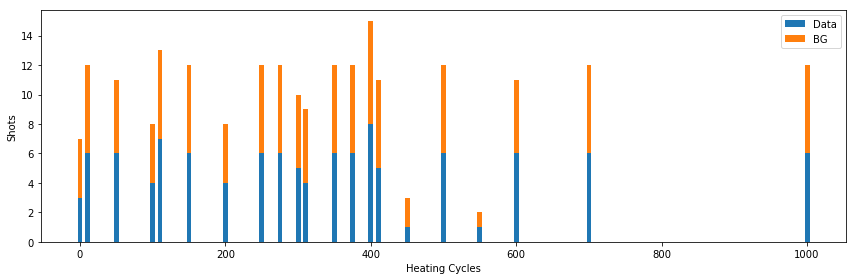

In [2182]:
# Dataset Explorer 
bg_variable = 'SeqMode'
bg_value = 11

# Count number of images 
unique_x = np.unique(df.x)
data_counts = np.array([np.sum(df.x[df[bg_variable] != bg_value].values == x) for x in unique_x])
bg_counts = np.array([np.sum(df.x[df[bg_variable] == bg_value].values == x) for x in unique_x])
dataset_counter = [unique_x, data_counts, bg_counts]

# Plot counter 
def makeplot_dataset_counter_barchart(ax, count = dataset_counter):
    if len(count[0]) > 1: width = np.min(np.diff(count[0]))/1.5
    else: width = 1
    ax.bar(count[0], count[1], width, label='Data')
    ax.bar(count[0], count[2], width, bottom=count[1], label='BG')
    ax.legend()
    ax.set(xlabel = WID_xlabel.value, ylabel='Shots')
    
fig, ax = plt.subplots(figsize=[12, 4])
makeplot_dataset_counter_barchart(ax)
plt.tight_layout()

In [2154]:
# Compute df_data : delta_rho and delta_rho_rho for datasets with both bg and data images with some threshold 

# inputs 
threshold_image_num = 1

# n(z) 
df['nz_raw'] = [im.nz for im in tqdm(df.image, desc='n(z)')]

# Fitting erf to get center and box length 
guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x
df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

# Process particular x 
def process_particular_x(x, ):
    # collect bg and data ind for this x 
    bg_ind = (df[bg_variable] == bg_value) & (df.x == x)
    data_ind = (df[bg_variable] != bg_value) & (df.x == x)
    
    # compute parameters 
    length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
    amp = np.mean([fr[4] for fr in df.fitres_erf[bg_ind | data_ind]])
    freq = np.unique(df.BoxShakeFreq[bg_ind | data_ind])[0]
    cycles = np.unique(df.ShakingCycles[bg_ind | data_ind])[0]
    
    # Get all nz
    nz_bg_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
             (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
    nz_data_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
             (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]
    
    # Average nz 
    nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
    nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
    nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
    nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
    
    # compute delta rho 
    x = nz_bg.x.copy()
    delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
    delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )
    
    # return 
    return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
            nz_bg_all, length, amp, np.sum(data_ind), 
            np.sum(bg_ind), freq, cycles)
    

# df_data 
df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                'nz bg', 'nz data all', 'nz bg all', 'length', 
                                'amp', '# data', '# bg', 'freq', 'cycles'])
for i, x in enumerate(dataset_counter[0]):
    if (dataset_counter[1][i] >= threshold_image_num) and (dataset_counter[2][i] >= threshold_image_num):
        df_data.loc[x] = process_particular_x(x)
        

## FT Wavelength 

In [2184]:
# FT Setup 
L = np.mean(df_data.length)
k = np.arange(0, 30*twopi/L, 0.1*twopi/L)
use = 'Delta rho / rho'
# use = 'Delta rho'
z_lims = np.array([15, 65]) * 1e-6
speed_sound_guess = 17.5 * 1e-6/1e-3
test = 0

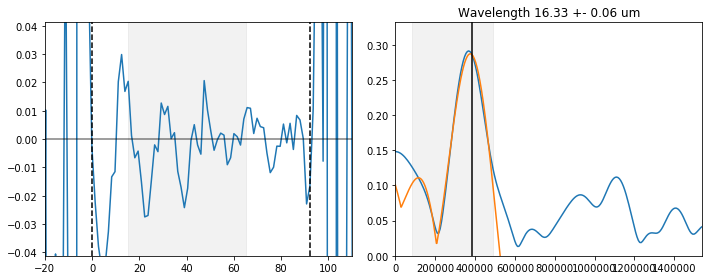

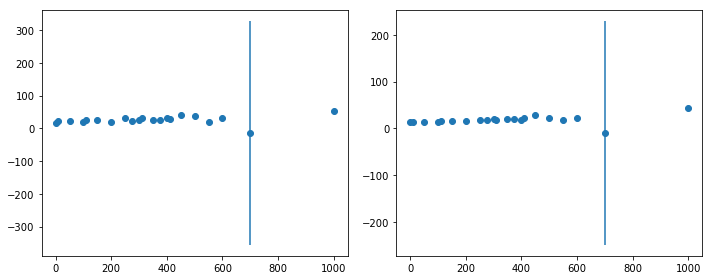

In [2185]:
# Compute Wavelength for all 

def fitfun(x, x0=0, amp=1, scale=1, offset=0, gradient=0):
    return amp * np.abs(np.sinc((x-x0) / scale)) + offset + gradient * x 

wavelengths = []

for x, r in df_data.iterrows():
    # Get FT 
    c = r[use].trim(xlim=z_lims)
    y_ft = fourier_transform(c, k)
    c_ft = tp.Curve(k, np.abs(y_ft) * 1e6)
    
    # Fit Sinc 
    guess = [twopi*r.freq / speed_sound_guess, c_ft.y.max(), twopi / (z_lims[1] - z_lims[0]), c_ft.maxy / 1000, c_ft.maxy / 100000]
    fit_lims = [guess[0] - 3 * twopi/L, guess[0] + 3 * twopi/L]
    fr, fe = c_ft.fit(fitfun, guess, plot=False, xlim=fit_lims)
    
    # Extract wavelength and error 
    wavelengths.append([twopi*1e6/fr[0], twopi*1e6 * fe[0]/fr[0]**2])
wavelengths = np.array(wavelengths)

## Test Plotter 
# Get test 
r = df_data.iloc[test]

# Get FT 
c = r[use].trim(xlim=z_lims)
y_ft = fourier_transform(c, k)
c_ft = tp.Curve(k, np.abs(y_ft) * 1e6)

# Fit Sinc 
guess = [twopi*r.freq / speed_sound_guess, c_ft.y.max(), twopi / (z_lims[1] - z_lims[0]), c_ft.maxy / 1000, c_ft.maxy / 100000]
fit_lims = [guess[0] - 3 * twopi/L, guess[0] + 3 * twopi/L]
fr, fe = c_ft.fit(fitfun, guess, plot=False, xlim=fit_lims)

plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.plot(r[use].x*1e6, r[use].y)
plt.axvline(0, c='k', linestyle='--', )
plt.axvline(L*1e6, c='k', linestyle='--', )
plt.axhline(0, c='k', linestyle='-', alpha=0.5)
plt.axvspan(*z_lims*1e6, alpha=0.05, color='k', label='Fourier Width')
amp = np.max(np.abs(c.y)) * 1.5
plt.ylim([-amp, amp])
plt.xlim([-20, 110])

plt.subplot(122)
plt.plot(*c_ft.data)
plt.plot(*c_ft.xyfitplot)
plt.axvline(fr[0], c='k',)
plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
plt.ylim([0, None])
plt.xlim([0, fr[0]*4])
plt.title('Wavelength {:.2f} +- {:.2f} um'.format(twopi*1e6/fr[0], twopi*1e6 * fe[0]/fr[0]**2))
plt.tight_layout()

## Data Plotter 
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.errorbar(df_data.index.values, wavelengths[:, 0], wavelengths[:, 1], fmt='o')
plt.subplot(122)
plt.errorbar(df_data.index.values, df_data.freq.values*wavelengths[:, 0]/1e3, df_data.freq.values*wavelengths[:, 1]/1e3, fmt='o')
plt.tight_layout()

## Single Sided Decay Fits

In [2186]:
# Dataset Info 
speed_sound_guess = 20 * 1e-6/1e-3
fit_lims = [15, 70]
plot_lims = [-10, 100]

In [2187]:
# Single Sided Fit -- 0:DecayLength, 1:Wavelength, 2:Amplitude, 3:Phase, 4:Offset, 5:Gradient, 6:speed, 7:gamma 
def single_analyzer(c, freq, fit_lims, guess_wavelength, plot=False, plot_lims=[-10, 100], plot_res = False): 
    # Fit Exp Decay 
    guess = [50.0, guess_wavelength, 0.04, np.pi, 1e-2, 1e-4,]
    
    # Define Fit function 
    fit_vars = ['Decay Length [um]', 'Wavelength [um]', 'Amplitude at Wall', 'Phase at Wall', 'Offset          ', 'Gradient         ', 'Curvature          ']
    def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
        return np.exp(-x/l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

    # Prepare and fit data 
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
    speed_sound = [freq * fr[1] * 1e-6, freq * fe[1] * 1e-6]
    gamma = [speed_sound[0] / fr[0] / 1e-6, ((speed_sound[1] / (fr[0]*1e-6))**2 + (speed_sound[0] * fe[0] * 1e-6 / (fr[0]*1e-6)**2)**2)**(1/2)]
    
    #  resutls 
    if fr[2] < 0:
        fr[2] = - fr[2]
        fr[3] = fr[3] + np.pi
    fr[3] = np.mod(fr[3], twopi)
    
    
    # Print fit results 
    if plot:
        for i in range(len(fr)):
            print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

        print('\nSpeed of Sound   {:.2f} +- {:.2f} um/ms'.format(speed_sound[0]*1e3, speed_sound[1]*1e3))
        print('Decay Rate Gamma {:.2f} +- {:.2f} Hz'.format(gamma[0]/twopi, gamma[1]/twopi))
    
    # Plot Results 
    if plot:
        plt.figure()
        plt.plot(*c.xyfitplot, 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(L*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 1, 0, *fr[3:]]), 'C2-', alpha=0.5)
        amp = fr[2] * 1.5
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.tight_layout()
    if plot_res:  
        plt.figure()
        plt.plot(c.x, c.y - fitfun_sin_decay(c.x, *fr), )
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(L*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.xlim(plot_lims)
        plt.ylim(-0.012, 0.012)
        plt.tight_layout()

    return [list(fr)+[speed_sound[0],gamma[0]], list(fe)+[speed_sound[1],gamma[1]]]

In [2188]:
# Single Sided Fit -- 0:DecayLength, 1:Wavelength, 2:Amplitude, 3:Phase, 4:Offset, 5:Gradient, 6:speed, 7:gamma 
def single_analyzer(c, freq, fit_lims, guess_wavelength, plot=False, plot_lims=[-10, 100], plot_res = False, phase=np.pi): 
    # Fit Exp Decay 
    guess = [50.0, guess_wavelength, c.trim(xlim=fit_lims).maxy*2, phase, c.trim(xlim=fit_lims).maxy/100, ]
    
    # Define Fit function 
    fit_vars = ['Decay Length [um]', 'Wavelength [um]', 'Amplitude at Wall', 'Phase at Wall', 'Offset          ', 'Gradient         ', 'Curvature          ']
    def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
        return np.exp(-x/l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

    # Prepare and fit data 
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
    fr = np.array(list(fr) + [0,])
    fe = np.array(list(fe) + [0,])
    speed_sound = [freq * fr[1] * 1e-6, freq * fe[1] * 1e-6]
    gamma = [speed_sound[0] / fr[0] / 1e-6, ((speed_sound[1] / (fr[0]*1e-6))**2 + (speed_sound[0] * fe[0] * 1e-6 / (fr[0]*1e-6)**2)**2)**(1/2)]
    
    #  resutls 
    if fr[2] < 0:
        fr[2] = - fr[2]
        fr[3] = fr[3] + np.pi
    fr[3] = np.mod(fr[3], twopi)
    
    
    # Print fit results 
    if plot:
        for i in range(len(fr)):
            print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

        print('\nSpeed of Sound   {:.2f} +- {:.2f} um/ms'.format(speed_sound[0]*1e3, speed_sound[1]*1e3))
        print('Decay Rate Gamma {:.2f} +- {:.2f} Hz'.format(gamma[0]/twopi, gamma[1]/twopi))
    
    # Plot Results 
    if plot:
        plt.figure()
        plt.plot(*c.xyfitplot, 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(L*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 1, 0, *fr[3:]]), 'C2-', alpha=0.5)
        amp = fr[2] * 1.5
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.tight_layout()
    if plot_res:  
        plt.figure()
        plt.plot(c.x, c.y - fitfun_sin_decay(c.x, *fr), )
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(L*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.xlim(plot_lims)
        plt.ylim(-0.012, 0.012)
        plt.tight_layout()

    return [list(fr)+[speed_sound[0],gamma[0]], list(fe)+[speed_sound[1],gamma[1]]]

In [2269]:
# Single Sided Fit -- 0:InvDevayLength, 1:Wavelength, 2:Amplitude, 3:Phase, 4:Offset, 5:Gradient, 6:speed, 7:gamma 
def single_analyzer(c, freq, fit_lims, guess_wavelength, plot=False, plot_lims=[-10, 100], plot_res = False, phase=np.pi): 
    # Fit Exp Decay 
    guess = [1/50.0, guess_wavelength, c.trim(xlim=fit_lims).maxy*2, phase, c.trim(xlim=fit_lims).maxy/100, ]
    
    # Define Fit function 
    fit_vars = ['Inv Decay Length [1/um]', 'Wavelength [um]', 'Amplitude at Wall', 'Phase at Wall', 'Offset          ', 'Gradient         ', 'Curvature          ']
    def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
        return np.exp(-x*l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

    # Prepare and fit data 
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
    fr = np.array(list(fr) + [0,])
    fe = np.array(list(fe) + [0,])
    speed_sound = [freq * fr[1] * 1e-6, freq * fe[1] * 1e-6]
    gamma = [speed_sound[0] * fr[0] * 1e6, ((fr[0] * speed_sound[1])**2 + (fe[0] * speed_sound[0])**2)**(1/2) * 1e6]
    
    #  resutls 
    if fr[2] < 0:
        fr[2] = - fr[2]
        fr[3] = fr[3] + np.pi
    fr[3] = np.mod(fr[3], twopi)
    
    
    # Print fit results 
    if plot:
        for i in range(len(fr)):
            print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

        print('\nSpeed of Sound   {:.2f} +- {:.2f} um/ms'.format(speed_sound[0]*1e3, speed_sound[1]*1e3))
        print('Decay Rate Gamma {:.2f} +- {:.2f} Hz'.format(gamma[0]/twopi, gamma[1]/twopi))
    
    # Plot Results 
    if plot:
        plt.figure()
        plt.plot(*c.xyfitplot, 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(L*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 1, 0, *fr[3:]]), 'C2-', alpha=0.5)
        amp = fr[2] * 1.2
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.tight_layout()
    if plot_res:  
        plt.figure()
        plt.plot(c.x, c.y - fitfun_sin_decay(c.x, *fr), )
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(L*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.xlim(plot_lims)
        plt.ylim(-0.012, 0.012)
        plt.tight_layout()

    return [list(fr)+[speed_sound[0],gamma[0]], list(fe)+[speed_sound[1],gamma[1]]]

### Fit Averaged

-------------- 0.0 --------------
Inv Decay Length [1/um] 	 0.0351 +- 0.00949
Wavelength [um] 	 17.0 +- 0.386
Amplitude at Wall 	 0.0447 +- 0.0108
Phase at Wall 	 3.57 +- 0.203
Offset           	 -0.00249 +- 0.00122
Gradient          	 0.0 +- 0.0

Speed of Sound   13.60 +- 0.31 um/ms
Decay Rate Gamma 75.95 +- 20.61 Hz


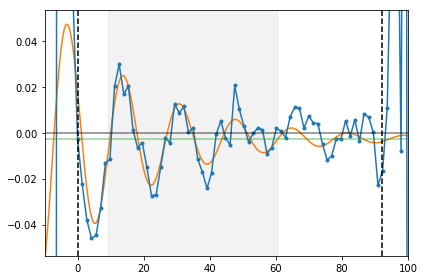

-------------- 10.0 --------------
Inv Decay Length [1/um] 	 0.00973 +- 0.00742
Wavelength [um] 	 22.6 +- 0.526
Amplitude at Wall 	 0.0326 +- 0.00832
Phase at Wall 	 3.68 +- 0.208
Offset           	 0.00219 +- 0.00157
Gradient          	 0.0 +- 0.0

Speed of Sound   13.53 +- 0.32 um/ms
Decay Rate Gamma 20.95 +- 15.98 Hz


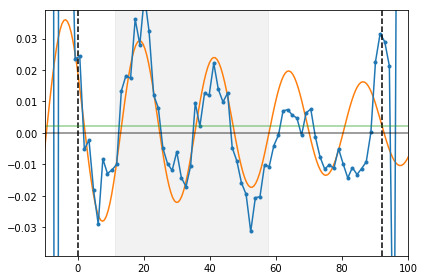

-------------- 50.0 --------------
Inv Decay Length [1/um] 	 0.0142 +- 0.00612
Wavelength [um] 	 22.7 +- 0.505
Amplitude at Wall 	 0.0356 +- 0.00759
Phase at Wall 	 4.27 +- 0.205
Offset           	 -0.00254 +- 0.00111
Gradient          	 0.0 +- 0.0

Speed of Sound   13.61 +- 0.30 um/ms
Decay Rate Gamma 30.66 +- 13.27 Hz


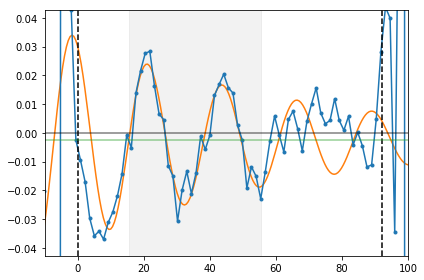

-------------- 100.0 --------------
Inv Decay Length [1/um] 	 0.0271 +- 0.00933
Wavelength [um] 	 18.3 +- 0.441
Amplitude at Wall 	 0.0349 +- 0.0093
Phase at Wall 	 3.26 +- 0.228
Offset           	 -0.00132 +- 0.00127
Gradient          	 0.0 +- 0.0

Speed of Sound   14.64 +- 0.35 um/ms
Decay Rate Gamma 63.23 +- 21.78 Hz


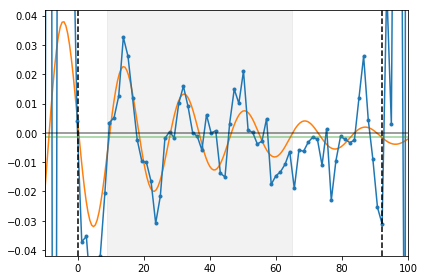

-------------- 110.0 --------------
Inv Decay Length [1/um] 	 0.0305 +- 0.00664
Wavelength [um] 	 24.4 +- 0.589
Amplitude at Wall 	 0.0582 +- 0.0125
Phase at Wall 	 3.98 +- 0.191
Offset           	 -0.000962 +- 0.0011
Gradient          	 0.0 +- 0.0

Speed of Sound   14.63 +- 0.35 um/ms
Decay Rate Gamma 71.13 +- 15.55 Hz


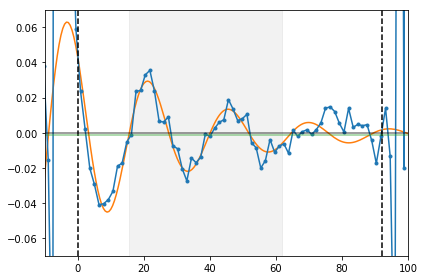

-------------- 150.0 --------------
Inv Decay Length [1/um] 	 0.0267 +- 0.00582
Wavelength [um] 	 24.6 +- 0.513
Amplitude at Wall 	 0.0553 +- 0.0111
Phase at Wall 	 4.36 +- 0.168
Offset           	 0.00119 +- 0.00103
Gradient          	 0.0 +- 0.0

Speed of Sound   14.77 +- 0.31 um/ms
Decay Rate Gamma 62.78 +- 13.75 Hz


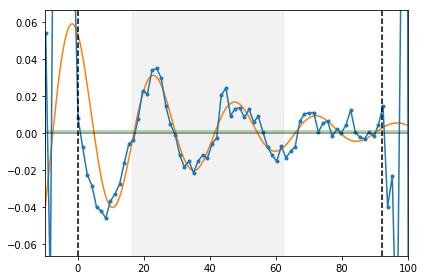

-------------- 200.0 --------------
Inv Decay Length [1/um] 	 0.0575 +- 0.0112
Wavelength [um] 	 19.6 +- 0.567
Amplitude at Wall 	 0.0721 +- 0.019
Phase at Wall 	 4.12 +- 0.192
Offset           	 0.000779 +- 0.000894
Gradient          	 0.0 +- 0.0

Speed of Sound   15.64 +- 0.45 um/ms
Decay Rate Gamma 143.25 +- 28.22 Hz


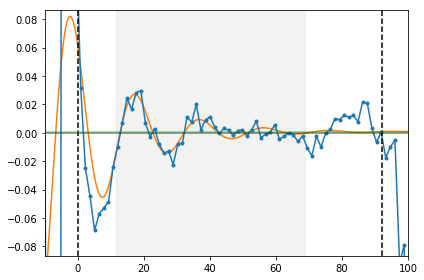

-------------- 250.0 --------------
Inv Decay Length [1/um] 	 0.0267 +- 0.00799
Wavelength [um] 	 29.1 +- 1.0
Amplitude at Wall 	 0.0434 +- 0.0129
Phase at Wall 	 3.89 +- 0.262
Offset           	 0.00344 +- 0.0011
Gradient          	 0.0 +- 0.0

Speed of Sound   17.46 +- 0.60 um/ms
Decay Rate Gamma 74.10 +- 22.35 Hz


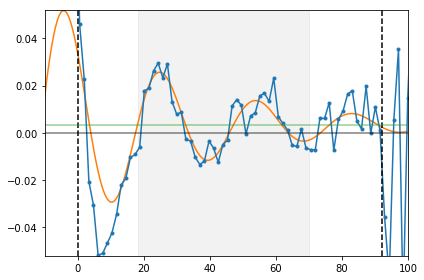

-------------- 275.0 --------------
Inv Decay Length [1/um] 	 0.0366 +- 0.00792
Wavelength [um] 	 22.2 +- 0.537
Amplitude at Wall 	 0.0441 +- 0.009
Phase at Wall 	 3.09 +- 0.158
Offset           	 -0.0002 +- 0.000965
Gradient          	 0.0 +- 0.0

Speed of Sound   17.76 +- 0.43 um/ms
Decay Rate Gamma 103.39 +- 22.52 Hz


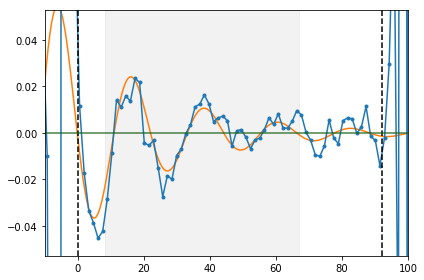

-------------- 300.0 --------------
Inv Decay Length [1/um] 	 0.0252 +- 0.00677
Wavelength [um] 	 24.1 +- 0.566
Amplitude at Wall 	 0.0369 +- 0.0084
Phase at Wall 	 3.56 +- 0.186
Offset           	 0.0014 +- 0.000998
Gradient          	 0.0 +- 0.0

Speed of Sound   19.26 +- 0.45 um/ms
Decay Rate Gamma 77.18 +- 20.81 Hz


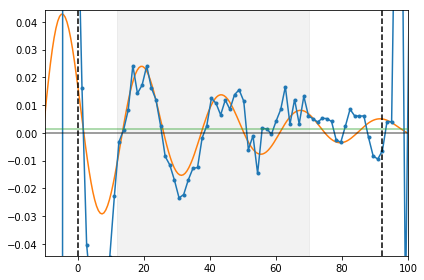

-------------- 310.0 --------------
Inv Decay Length [1/um] 	 0.0163 +- 0.0056
Wavelength [um] 	 30.5 +- 0.662
Amplitude at Wall 	 0.0426 +- 0.00979
Phase at Wall 	 4.2 +- 0.178
Offset           	 0.00396 +- 0.00111
Gradient          	 0.0 +- 0.0

Speed of Sound   18.30 +- 0.40 um/ms
Decay Rate Gamma 47.36 +- 16.33 Hz


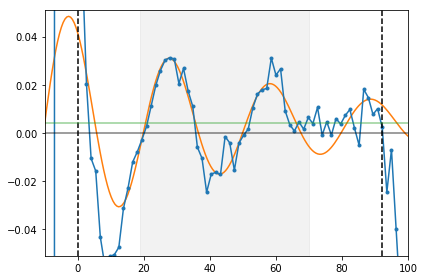

-------------- 350.0 --------------
Inv Decay Length [1/um] 	 0.0544 +- 0.00924
Wavelength [um] 	 26.1 +- 0.764
Amplitude at Wall 	 0.0972 +- 0.0218
Phase at Wall 	 0.0951 +- 0.147
Offset           	 -0.00421 +- 0.00114
Gradient          	 0.0 +- 0.0

Speed of Sound   20.87 +- 0.61 um/ms
Decay Rate Gamma 180.66 +- 31.13 Hz


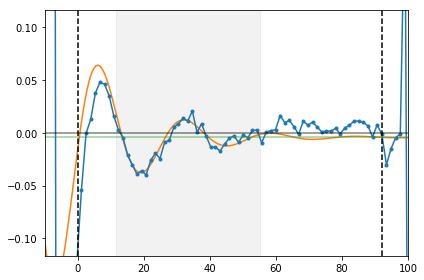

-------------- 375.0 --------------
Inv Decay Length [1/um] 	 0.0611 +- 0.00758
Wavelength [um] 	 28.4 +- 0.717
Amplitude at Wall 	 0.127 +- 0.0208
Phase at Wall 	 5.46 +- 0.0971
Offset           	 0.00374 +- 0.001
Gradient          	 0.0 +- 0.0

Speed of Sound   22.76 +- 0.57 um/ms
Decay Rate Gamma 221.39 +- 28.01 Hz


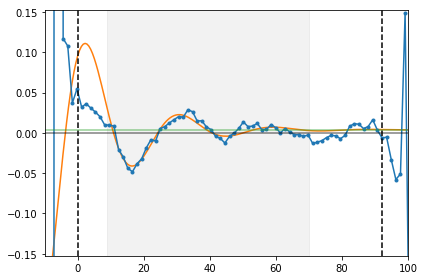

-------------- 400.0 --------------
Inv Decay Length [1/um] 	 0.00291 +- 0.00376
Wavelength [um] 	 32.3 +- 0.575
Amplitude at Wall 	 0.0233 +- 0.00417
Phase at Wall 	 4.37 +- 0.155
Offset           	 0.00365 +- 0.000758
Gradient          	 0.0 +- 0.0

Speed of Sound   19.40 +- 0.34 um/ms
Decay Rate Gamma 8.98 +- 11.62 Hz


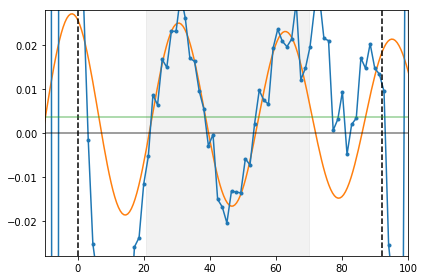

-------------- 410.0 --------------
Inv Decay Length [1/um] 	 0.0549 +- 0.0139
Wavelength [um] 	 28.2 +- 1.35
Amplitude at Wall 	 0.143 +- 0.0711
Phase at Wall 	 5.61 +- 0.336
Offset           	 0.00194 +- 0.00129
Gradient          	 0.0 +- 0.0

Speed of Sound   22.59 +- 1.08 um/ms
Decay Rate Gamma 197.24 +- 50.82 Hz


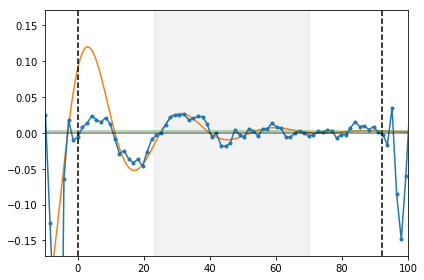

-------------- 450.0 --------------
Inv Decay Length [1/um] 	 0.0513 +- 0.00922
Wavelength [um] 	 35.7 +- 1.48
Amplitude at Wall 	 0.275 +- 0.0803
Phase at Wall 	 6.25 +- 0.211
Offset           	 0.00338 +- 0.00254
Gradient          	 0.0 +- 0.0

Speed of Sound   24.96 +- 1.03 um/ms
Decay Rate Gamma 203.85 +- 37.58 Hz


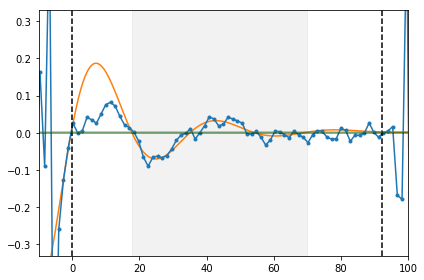

-------------- 500.0 --------------
Inv Decay Length [1/um] 	 0.0223 +- 0.0071
Wavelength [um] 	 37.4 +- 0.982
Amplitude at Wall 	 0.0558 +- 0.0171
Phase at Wall 	 4.33 +- 0.177
Offset           	 0.00665 +- 0.00107
Gradient          	 0.0 +- 0.0

Speed of Sound   22.41 +- 0.59 um/ms
Decay Rate Gamma 79.58 +- 25.41 Hz


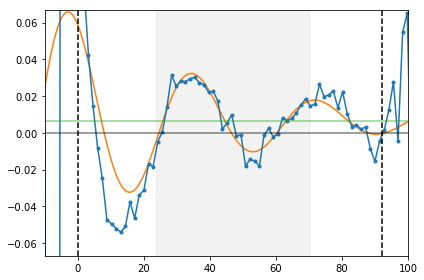

-------------- 550.0 --------------
Inv Decay Length [1/um] 	 0.0501 +- 0.0217
Wavelength [um] 	 27.2 +- 2.05
Amplitude at Wall 	 0.122 +- 0.0788
Phase at Wall 	 3.98 +- 0.447
Offset           	 0.00656 +- 0.00317
Gradient          	 0.0 +- 0.0

Speed of Sound   24.52 +- 1.85 um/ms
Decay Rate Gamma 195.43 +- 85.88 Hz


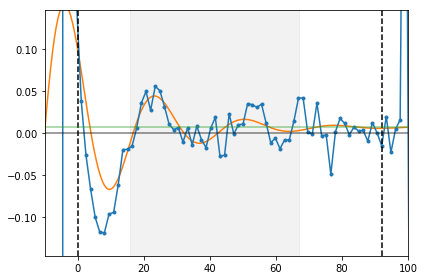

-------------- 600.0 --------------
Inv Decay Length [1/um] 	 0.0243 +- 0.00794
Wavelength [um] 	 36.2 +- 1.39
Amplitude at Wall 	 0.0502 +- 0.017
Phase at Wall 	 4.07 +- 0.257
Offset           	 0.00636 +- 0.00115
Gradient          	 0.0 +- 0.0

Speed of Sound   25.37 +- 0.97 um/ms
Decay Rate Gamma 97.92 +- 32.29 Hz


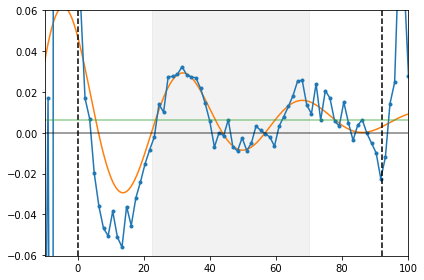

-------------- 700.0 --------------
Inv Decay Length [1/um] 	 0.0402 +- 0.0102
Wavelength [um] 	 40.4 +- 1.55
Amplitude at Wall 	 0.104 +- 0.0404
Phase at Wall 	 0.485 +- 0.196
Offset           	 -0.0012 +- 0.00133
Gradient          	 0.0 +- 0.0

Speed of Sound   28.27 +- 1.08 um/ms
Decay Rate Gamma 181.08 +- 46.29 Hz


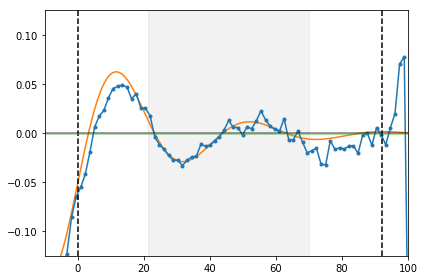

-------------- 1000.0 --------------
Inv Decay Length [1/um] 	 0.0944 +- 0.0182
Wavelength [um] 	 36.3 +- 2.43
Amplitude at Wall 	 0.426 +- 0.223
Phase at Wall 	 0.253 +- 0.258
Offset           	 -0.00188 +- 0.00122
Gradient          	 0.0 +- 0.0

Speed of Sound   29.04 +- 1.94 um/ms
Decay Rate Gamma 436.56 +- 88.88 Hz


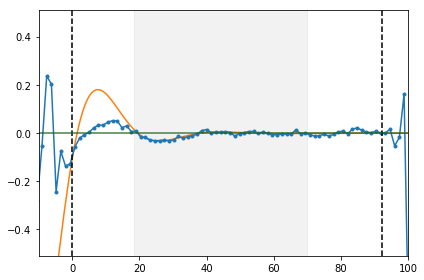

In [2270]:
# Fit and plot all data 
frs = []
fes = []


for x, r in df_data.iterrows():
    print('-------------- {} --------------'.format(x))
    c = tp.Curve(r[use].x*1e6, r[use].y)
    speed_sound_guess = (13 + (26-13)/600 * x)  * 1e-6/1e-3
    cycle_ = r.cycles - int(r.cycles)
    if cycle_ >= 0.25 and cycle_ < 0.75: 
        fit_lims_ = [c.x[(c.x > 10) & (c.y < 0)][0] - 2, fit_lims[1]]
        phase = 0
    else:
        fit_lims_ = [c.x[(c.x > 10) & (c.y > 0)][0] - 2, fit_lims[1]]
        phase = np.pi
    fr, fe = single_analyzer(c, r.freq, fit_lims_, speed_sound_guess / r.freq * 1e6, False, plot_lims, False, phase)
    fit_lims_ = [fit_lims_[0], min(fit_lims[1], fr[1]*(r.cycles-0.5))]
    fr, fe = single_analyzer(c, r.freq, fit_lims_, fr[6] / r.freq * 1e6, True, plot_lims)
    frs.append(fr)
    fes.append(fe)
    plt.show()
    
frs = np.array(frs)
fes = np.array(fes) 

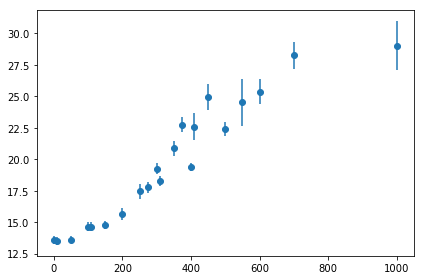

In [2271]:
# Plot Raw Results 
plot_res = 6

scales = [1, 1, 1, np.pi, 1, 1, 1e-3, twopi]
plt.errorbar(df_data.index.values, frs[:, plot_res]/scales[plot_res], fes[:, plot_res]/scales[plot_res], fmt='o',)
# plt.ylim([0, None])
# plt.xlim([0, None])
plt.tight_layout()

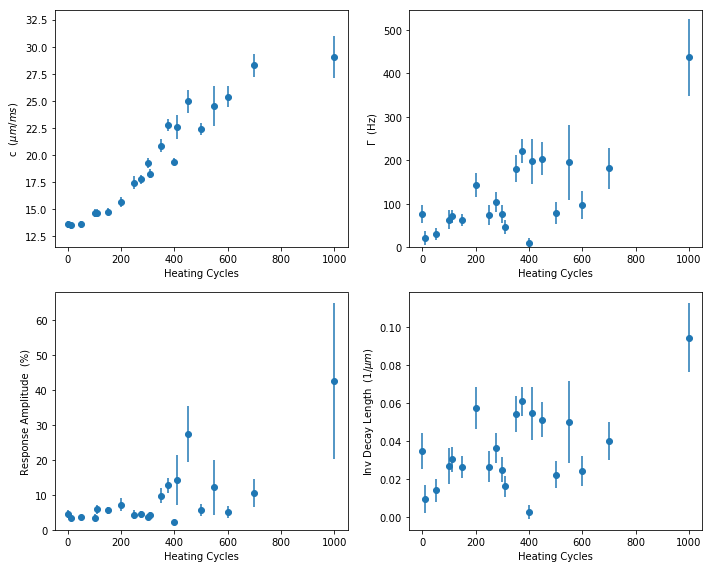

In [2273]:
# Plot various things 
c_lim = [0.85*np.min(frs[:, 6]*1e3), 1.15*np.max(frs[:, 6]*1e3)]
g_lim = [0, 1.25*np.max(frs[:, 7]/twopi)]
l_lim = [None, None]
x_lim = [36, 53]
x_lim = [None, None]
xlabel = WID_xlabel.value

x = df_data.index.values
amp_mult = 100
xp = frs[:, 2]*amp_mult

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[10, 8])
ax = ax.flatten()

ax[0].errorbar(x, frs[:, 6]*1e3, fes[:, 6]*1e3, fmt='o')
ax[0].set(ylabel=r'c  ($\mu m / ms$)', xlim=x_lim, ylim=c_lim, xlabel=xlabel)

ax[1].errorbar(x, frs[:, 7]/twopi, fes[:, 7]/twopi, fmt='o')
ax[1].set(ylabel=r'$\Gamma$  (Hz)', xlim=x_lim, ylim=g_lim, xlabel=xlabel)

ax[2].errorbar(x, frs[:, 2]*amp_mult, fes[:, 2]*amp_mult, fmt='o')
ax[2].set(ylabel=r'Response Amplitude  (%)', xlim=x_lim, ylim=[0, None], xlabel=xlabel)

ax[3].errorbar(x, frs[:, 0], fes[:, 0], fmt='o')
ax[3].set(ylabel=r'Inv Decay Length  (1/$\mu m$)', ylim=l_lim, xlim=x_lim, xlabel=xlabel, )

plt.tight_layout()

# Energy of Box

In [2302]:
# Used Functions 

def compute_moment(nz, zlim=550):
    using = (nz.x >= -zlim*1e-6) & (nz.x <= zlim*1e-6)
    nz = tp.Curve(nz.x[using], nz.y[using])
    return np.trapz(nz.y*nz.x**2, nz.x) / np.trapz(nz.y, nz.x)

def gaussian_fit_sigma(nz, plot=False):
    guess = [1e-6, 20e-6, nz.maxy, nz.maxy/1000]
    fr = nz.fit(gaussian, guess, plot=plot)[0]
    res = np.sum((nz.y - gaussian(nz.x, *fr))**2)
    return (fr[1], res)

def erf(x, x0, sigma):
    return scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, amp, x0, sigma):
    return erf(x, x0, sigma) * amp

def compute_moment_v2(nz, cutoff, plot=False, ax = None):
    # Compute moment vs cutoffs
    zlims = np.linspace(cutoff[0], cutoff[2], 100)
    moment = np.array([abs(compute_moment(nz, zlim=z)) for z in zlims])**0.5 * 1e6
    c_ = tp.Curve(zlims, moment)
    c_.removenan()
    
    # Fit
    sigma = c_.x**2/cutoff[1]**2
    sigma[c_.x <= cutoff[1]] = 1
    fr1 = scipy.optimize.curve_fit(fitfun_erf, c_.x, c_.y, p0=[55, 0, 50])[0]
    fr2 = scipy.optimize.curve_fit(fitfun_erf, c_.x, c_.y, p0=fr1, sigma=sigma)[0]
    
    # plot
    if plot:
        if ax is None: ax = plt.subplots()[1]
        ax.plot(*c_.data)
        ax.plot(c_.x, fitfun_erf(c_.x, *fr1), '-.', label='w/o')
        ax.plot(c_.x, fitfun_erf(c_.x, *fr2), label='w/')
        ax.plot(c_.x, 1/sigma * np.mean([fr1[0], fr2[0]]), 'k--', alpha=0.2, label='weight')
        ax.set(ylim=[c_.y.mean() * 0.6, c_.maxy*1.1])
        ax.legend(loc=2)
    
    # return
    return (fr2[0]*1e-6)**2

In [2303]:
# # One Time Setup 
# df_energy = get_from_clipboard(init=True)


Updating the local database...
Done


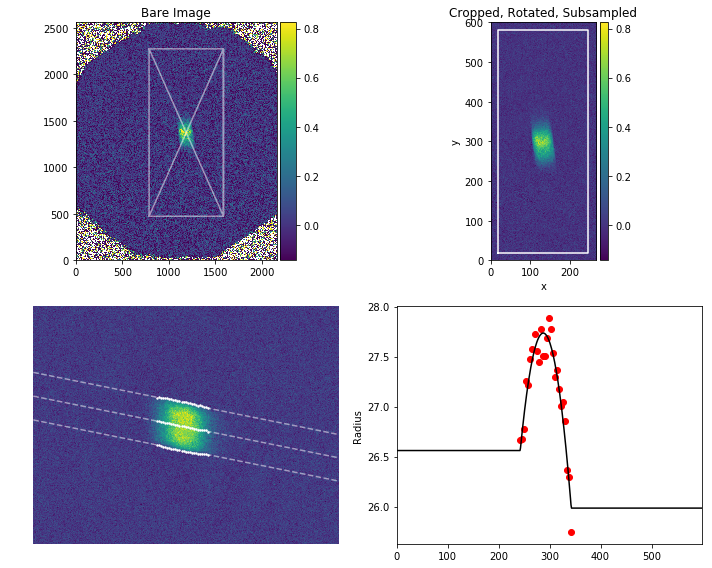

In [2305]:
# Load Images 

# Load Images
var = ['ExpansionTime','SideGreenEvap','WaitBox','IREvap','HeatTime','BoxShakeTime', 'ShakingCycles', 'BoxShakeAmp', 'BoxShakeFreq', 'Axial Grad Volt', 'SeqMode']
x_var = 'HeatCycles'
df_energy = get_from_clipboard(df=df_energy, x_var = x_var, image_func=tp.Hybrid_Image, var=var, using=0, display=False)
df_energy = df_energy[df_energy['SeqMode'] == 14]
df_energy.reset_index(drop=True, inplace=True)
# Crop images
settings = {**default_settings, 
            **dict(center_x = 1187, center_y = 1375, width = 800, height = 1800, fudge = 1.75)}
for i, r in df_energy.iterrows(): r.image.set(**settings)

# Test
test = 0
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df_energy.image.iloc[test].plot_crop(ax=ax[0:2])
ax[1].set(xlabel='x', ylabel='y')
# ax[2].plot(*df_energy.image.iloc[test].nz.plotdata)
# ax[2].set(xlabel='z [um]', ylabel='Density n [um^-3]')
df_energy.image.iloc[test].xsec.infoplot(axs = [ax[2],ax[3]])
plt.tight_layout()
plt.show()

100.0


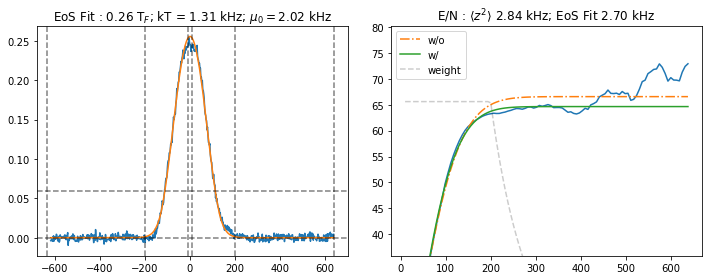

In [2306]:
# Test Temperature Fits and Second Moment Limits 

zlim_second_moment = np.array([10, 200, df_energy.image.iloc[0].nz.maxx*1e6])
kHz = 1e3 * cst.h
prefactor = 2 * cst.mass * df_energy.image.iloc[0].trap_w**2

# Test function
def test_func(test=0, ):
    # Get the image and compute it all 
    im = df_energy.image.iloc[test]
    im.T_kHz
    
    # Second moment
    nz = im.nz
    moment = compute_moment_v2(nz, zlim_second_moment)**0.5 * 1e6
    E_N_moment = prefactor * (moment*1e-6)**2 / kHz
    
    # Temperature
    Tfit_info = im.var['Tfit_info']
    nz_fit = tp.Curve(nz.x, Tfit_info[0](nz.x, *Tfit_info[1]), xscale=nz.xscale, yscale = nz.yscale)
    E_N_fit = hybrid_E_N(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f) / kHz
    
    # Plots
    print(df_energy.x.iloc[test])
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].plot(*nz.plotdata)
    ax[0].plot(*nz_fit.plotdata)
    ax[0].axhline(im.Tfit_lim, linestyle='--', c='k', alpha=0.5)
    ax[0].axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [*zlim_second_moment, *-zlim_second_moment]: ax[0].axvline(_, linestyle='--',c='k',alpha=0.5)
    compute_moment_v2(nz, zlim_second_moment, plot=True, ax=ax[1])
    ax[0].set(title='EoS Fit : {:.2f} T$_F$; kT = {:.2f} kHz; $\mu_0=${:.2f} kHz'.format(im.TTF_center, im.T_kHz, im.mu0_kHz) )
    ax[1].set(title=r"E/N : $\left< z^2 \right>$ {:.2f} kHz; EoS Fit {:.2f} kHz".format(E_N_moment, E_N_fit))
    fig.tight_layout()

if df_energy.shape[0] == 1:
    test_func(0)
else:
    ipywidgets.interact(test_func, test=(0, df_energy.shape[0]-1, 1));

In [2307]:
# Box Characteristics !!! CRUCIAL 

# Cross section for calculating EoS fit atom numebrs 
cross_section=np.pi*(59.38e-6)**2

# Box Volume for calculating E_F box 
box_volume = 88.28e-6 * cross_section



        Total Loaded Images 81
        Atom Num Filter     81
        Removed Images      0
        


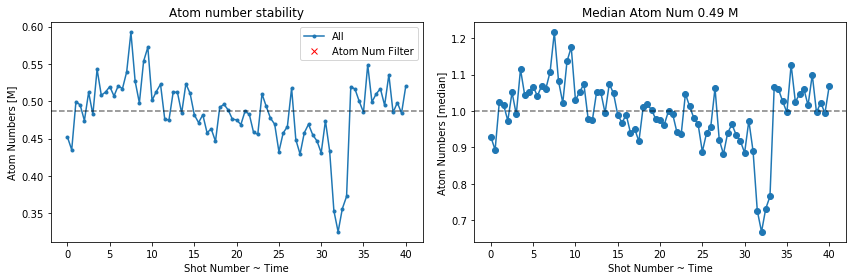

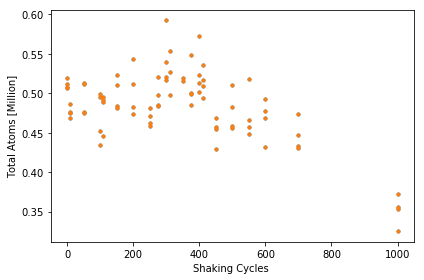

In [2308]:
# fit and bin all data 

# Atom Number Filter
df_energy['total_atoms'] = np.array([np.nansum(im.app) for im in tqdm(df_energy.image, desc='Atoms')])
using = atom_num_filter(df_energy, keep=0.40, offset=0.0)
plt.show()

# using = using & (df_energy['ShakingCycles'].values != 0)
# print('Removed BG Images {}'.format(np.sum(using)))

# Compute E/N for good images
EN_eos = np.array([hybrid_E_N(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f) for im in tqdm(df_energy.image[using], desc='EoS')])
EN_moment = np.array([prefactor * compute_moment_v2(im.nz, zlim_second_moment) for im in tqdm(df_energy.image[using], desc='Moment')])
temp_eos_atoms = np.array([hybrid_total_atoms(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f, cross_section) for im in tqdm(df_energy.image[using], desc='EoS')])

# Bin Data
EN_eos = bin_data(df_energy.x.values[using], EN_eos)
EN_moment = bin_data(df_energy.x.values[using], EN_moment)
total_atoms = bin_data(df_energy.x.values[using], df_energy.total_atoms.values[using])
total_atoms_fit = bin_data(df_energy.x.values[using], temp_eos_atoms)

# Plot atoms vs x 
plt.figure()
plt.plot(df_energy.x, df_energy.total_atoms/1e6,'.')
plt.plot(df_energy.x[using], df_energy.total_atoms[using]/1e6,'.')
# plt.xlabel('Shaking Frequency [Hz]')
plt.xlabel('Shaking Cycles ')
plt.ylabel('Total Atoms [Million]')
plt.tight_layout()

In [2296]:
# Information about the data 
unique, counts = np.unique(total_atoms[4], return_counts=True)
for i in range(unique.size):
    print(unique[i], '--', counts[i])

0.0 -- 4
10.0 -- 4
50.0 -- 4
100.0 -- 4
110.0 -- 4
150.0 -- 4
200.0 -- 4
250.0 -- 4
275.0 -- 4
300.0 -- 4
310.0 -- 3
350.0 -- 2
375.0 -- 4
400.0 -- 4
410.0 -- 4
450.0 -- 4
500.0 -- 4
550.0 -- 4
600.0 -- 4
700.0 -- 4
1000.0 -- 4


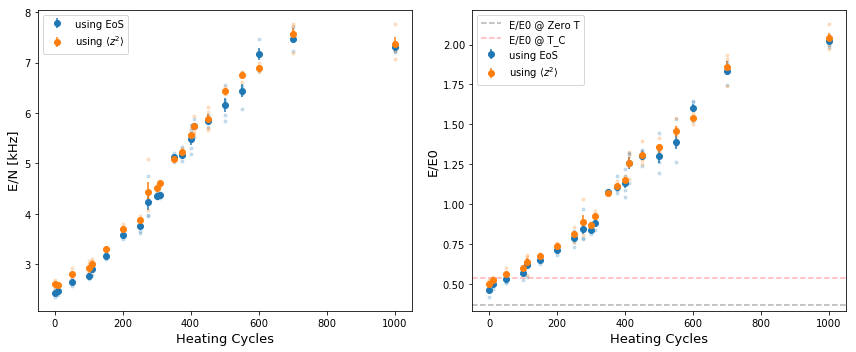

In [2297]:
# Simple Plot : E/N and E/E0 vs x_variable 
# xlabel = 'Wait time [s]'
# xlabel = 'Freq [Hz]'
xlabel = 'Heating Cycles'
# xlabel = 'Expansion Time [ms]'
ylabel = 'E/N [kHz]'
fontsize = 13

plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.errorbar(EN_eos[0], EN_eos[1]/kHz, yerr=EN_eos[2]/kHz, fmt='oC0', label='using EoS')
plt.plot(EN_eos[4], EN_eos[5]/kHz, '.C0', alpha=0.2)
plt.errorbar(EN_moment[0], EN_moment[1]/kHz, yerr=EN_moment[2]/kHz, fmt='oC1', label = r'using $\left< z^2 \right>$')
plt.plot(EN_moment[4], EN_moment[5]/kHz, '.C1', alpha=0.2)
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()

plt.subplot(122)
E_E0 = 5/3 * EN_eos[5] / cst.n2EF(total_atoms_fit[5] / box_volume)
E_E0_eos = bin_data(EN_eos[4], E_E0)
plt.errorbar(*E_E0_eos[0:3], fmt='o', label='using EoS')
plt.plot(E_E0_eos[4], E_E0_eos[5], '.C0', alpha=0.2)
E_E0 = 5/3 * EN_moment[5] / cst.n2EF(total_atoms_fit[5] / box_volume)
E_E0_moment = bin_data(EN_moment[4], E_E0)
plt.errorbar(*E_E0_moment[0:3], fmt='o', label=r'using $\left< z^2 \right>$')
plt.plot(E_E0_moment[4], E_E0_moment[5], '.C1', alpha=0.2)
plt.axhline(0.37, linestyle='--', color='k', alpha=0.3, label='E/E0 @ Zero T')
plt.axhline(0.54, linestyle='--', color='r', alpha=0.3, label='E/E0 @ T_C')
plt.ylabel('E/E0', fontsize=fontsize)
plt.xlabel(xlabel, fontsize=fontsize)
# plt.xlim([0, None])
plt.legend()
plt.tight_layout()


Fudge : 1.75
Box Volume : 977896 um^3
T/TF from EoS fit : 0.142
Fermi Energy : 7.994 +- 0.495 kHz
E/N from EoS fit  : 2.436 +- 0.027
E/N from moment   : 2.622 +- 0.029
E/E0 from EoS fit : 0.463 +- 0.015
E/E0 from moment  : 0.498 +- 0.012


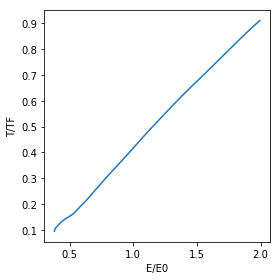

In [2298]:
# print some info 
print('Fudge : {}'.format(df_energy.image.iloc[0].fudge))
print('Box Volume : {:.0f} um^3'.format(box_volume*1e18))
c = tp.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
print("T/TF from EoS fit : {:.3f}".format(c(E_E0_eos[1][0])))
print('Fermi Energy : {:.3f} +- {:.3f} kHz'.format(cst.n2EFHz(np.mean(total_atoms[5])/box_volume)/1e3, np.std(cst.n2EFHz(np.array(total_atoms[5])/box_volume)/1e3)))
print("E/N from EoS fit  : {:.3f} +- {:.3f}".format(EN_eos[1][0]/kHz, EN_eos[2][0]/kHz))
print("E/N from moment   : {:.3f} +- {:.3f}".format(EN_moment[1][0]/kHz, EN_moment[2][0]/kHz))
print("E/E0 from EoS fit : {:.3f} +- {:.3f}".format(E_E0_eos[1][0], E_E0_eos[2][0]))
print("E/E0 from moment  : {:.3f} +- {:.3f}".format(E_E0_moment[1][0], E_E0_moment[2][0]))

plt.figure(figsize=[4,4])
plt.plot(*c.trim(xlim=[0, 2]).plotdata)
plt.xlabel('E/E0')
plt.ylabel('T/TF')
plt.tight_layout()

# Combined Plots

$$ m c^2 = \frac{10}{9} \frac{E}{N} $$
$$ \left( \frac{c}{v_F} \right)^2 = \frac{1}{3} \frac{E}{E_0} $$

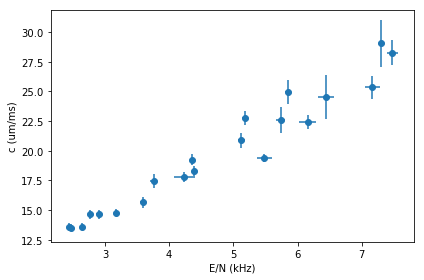

In [2299]:
# Plot Raw Results 
sound_speed = [df_data.index.values, frs[:, 6]/1e-3, fes[:, 6]/1e-3]
energy_particle = [EN_eos[0], EN_eos[1]/kHz, EN_eos[2]/kHz]

speed_energy = [energy_particle[1], sound_speed[1], energy_particle[2], sound_speed[2], ]

plt.errorbar(speed_energy[0], speed_energy[1], xerr=speed_energy[2], yerr=speed_energy[3], fmt='o')
plt.xlabel('E/N (kHz)')
plt.ylabel('c (um/ms)')
plt.tight_layout()

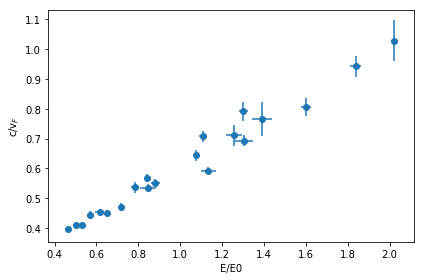

In [2300]:
# Plot Raw Results 
v_F = bin_data(EN_eos[4], (cst.n2EF(total_atoms_fit[5] / box_volume) * 2 / cst.mass)**(1/2))
v_F = v_F[1]
sound_speed = [df_data.index.values, frs[:, 6]/v_F, fes[:, 6]/v_F]
energy_particle = E_E0_eos[0:3]

speed_energy = [energy_particle[1], sound_speed[1], energy_particle[2], sound_speed[2], ]

plt.errorbar(speed_energy[0], speed_energy[1], xerr=speed_energy[2], yerr=speed_energy[3], fmt='o')
plt.xlabel('E/E0')
plt.ylabel(r'c/v$_F$')
plt.tight_layout()

[    0.    10.    50.   100.   110.   150.   200.   250.   275.   300.
   310.   350.   375.   400.   410.   450.   500.   550.   600.   700.
  1000.]


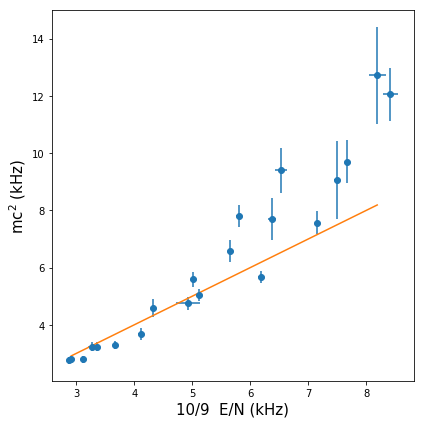

In [2301]:
# Plot Raw Results 
sound_speed = [df_data.index.values, cst.mass * frs[:, 6]**2 / kHz, 2 * cst.mass * frs[:, 6] * fes[:, 6] / kHz] 
energy_particle = [EN_eos[0], EN_eos[1]/kHz, EN_eos[2]/kHz]
energy_particle = [EN_moment[0], EN_moment[1]/kHz, EN_moment[2]/kHz]
print(energy_particle[0])
speed_energy = [10/9*(energy_particle[1]-0.), sound_speed[1], 10/9*energy_particle[2], sound_speed[2], ]

plt.figure(figsize=[6, 6])
plt.errorbar(speed_energy[0], speed_energy[1], xerr=speed_energy[2], yerr=speed_energy[3], fmt='o')
plt.plot([speed_energy[0][0], speed_energy[0][-1]], [speed_energy[0][0], speed_energy[0][-1]])
plt.xlabel('10/9  E/N (kHz)', fontsize=15)
plt.ylabel(r'mc$^2$ (kHz)', fontsize=15)
plt.tight_layout()

# Atom Numbers Shot B

In [2196]:
# ONLY ONCE -- Initialize empty dataframe and select options 
df_atoms = get_from_clipboard(init=True)

In [2197]:
# Import from Clipboard 
x_var = WID_x_var.value
using = 1
info = WID_info.value
df_atoms = get_from_clipboard(df=df_atoms, init=False, var=var, x_var=x_var, image_func=tp.Hybrid, using=using, display=info)

if WID_info.value:
    df_all.head(5) 


Updating the local database...
Done
Pasted Sample :  ['08-07-2017_23_49_04_TopA', '08-07-2017_23_49_04_TopB']
Newly added images       : 321
Total number of images   : 321


In [2206]:
# Sort Images 
select_energy = (df_atoms.SeqMode == 14)
select_refs = (df_atoms.SeqMode == 11)
select_shaken = (df_atoms.SeqMode == 16)

In [2211]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1181, center_y = 1370, width=800, height=800, fudge=1.75, subsample=2, 
                  xsec_extension='linear', xsec_slice_width=4, xsec_fit_range=1.0, radial_selection=0.5,)}

# Apply settings
for i, r in df_atoms.iterrows():
    r.image.set(**settings)


# Tests
if WID_info.value and False:
    r = df_atoms[select_refs].iloc[0]
    print(r.image.name)
    r.image.plot_crop()
    plt.show()
    r = df_atoms[select_shaken].iloc[0]
    print(r.image.name)
    r.image.plot_crop()
    plt.show()
    r = df_atoms[select_energy].iloc[0]
    print(r.image.name)
    r.image.plot_crop()
    plt.show()

In [2212]:
# Calculate atom numbers 
df_atoms['total_atoms'] = [im.total_atoms for im in tqdm(df_atoms.image)]

In [2251]:
# Average total atoms for each dataset 
x_all = df_data.index.values 

def quick_process(df_data, df_atoms, select, cnames):
    df_data[cnames[0]] = None
    df_data[cnames[1]] = None
    for x in x_all:
        a_ = df_atoms.loc[select & (df_atoms.x == x), 'total_atoms'] / 1e6
        df_data.loc[x, cnames[0]] = np.mean(a_)
        df_data.loc[x, cnames[1]] = np.std(a_)

quick_process(df_data, df_atoms, select_refs, ['Atoms Ref', 'Atoms Ref Error'])
quick_process(df_data, df_atoms, select_shaken, ['Atoms Shaken', 'Atoms Shaken Error'])
quick_process(df_data, df_atoms, select_energy, ['Atoms Energy', 'Atoms Energy Error'])
quick_process(df_data, df_energy, df_energy.SeqMode == 14.0, ['Atoms Energy A', 'Atoms Energy A Error'])
quick_process(df_data, df,  df.SeqMode == 11.0, ['Atoms Ref A', 'Atoms Ref A Error'])
quick_process(df_data, df,  df.SeqMode == 16.0, ['Atoms Shaken A', 'Atoms Shaken A Error'])

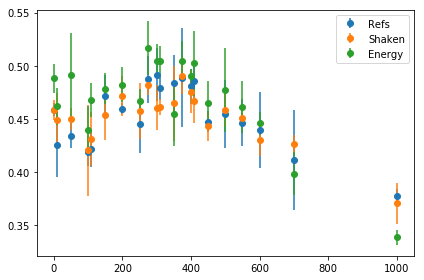

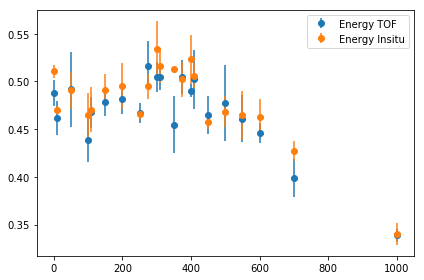

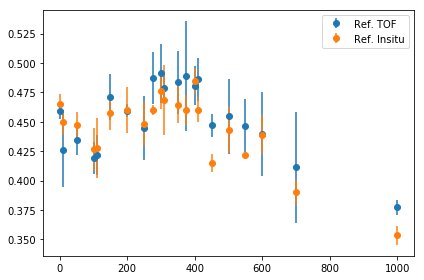

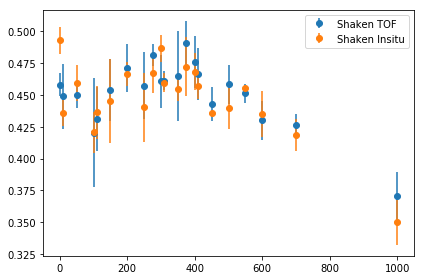

In [2275]:
# Plot Ratio of atom numbers 
atoms_ref = [df_data.index.values, df_data['Atoms Ref'].values, df_data['Atoms Ref Error'].values]
atoms_shaken = [df_data.index.values, df_data['Atoms Shaken'].values, df_data['Atoms Shaken Error'].values]
atoms_energy = [df_data.index.values, df_data['Atoms Energy'].values, df_data['Atoms Energy Error'].values]
atoms_energy_A = [df_data.index.values, df_data['Atoms Energy A'].values, df_data['Atoms Energy A Error'].values]
atoms_ref_A = [df_data.index.values, df_data['Atoms Ref A'].values, df_data['Atoms Ref A Error'].values]
atoms_shaken_A = [df_data.index.values, df_data['Atoms Shaken A'].values, df_data['Atoms Shaken A Error'].values]

plt.errorbar(*atoms_ref, fmt='o', label='Refs')
plt.errorbar(*atoms_shaken, fmt='o', label='Shaken')
plt.errorbar(*atoms_energy, fmt='o', label='Energy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(*atoms_energy, fmt='o', label='Energy TOF')
plt.errorbar(*atoms_energy_A, fmt='o', label='Energy Insitu')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(*atoms_ref, fmt='o', label='Ref. TOF')
plt.errorbar(*atoms_ref_A, fmt='o', label='Ref. Insitu')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(*atoms_shaken, fmt='o', label='Shaken TOF')
plt.errorbar(*atoms_shaken_A, fmt='o', label='Shaken Insitu')
plt.legend()
plt.tight_layout()
plt.show()

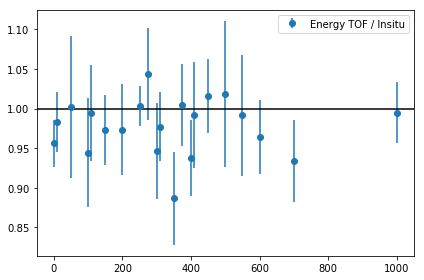

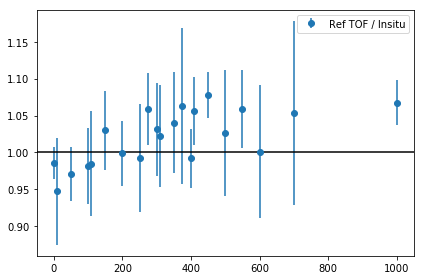

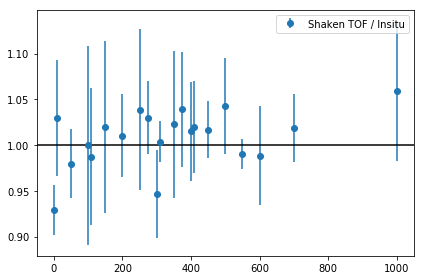

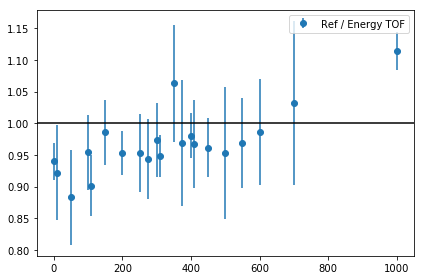

In [2287]:
def compute_ratio(a, b):
    return (a[0], a[1]/b[1], ((a[2] / b[1])**2 + (b[2] * a[1] / b[1]**2)**2)**(1/2))

plt.figure()
plt.errorbar(*compute_ratio(atoms_energy, atoms_energy_A), fmt='o', label='Energy TOF / Insitu')
plt.axhline(1, c='k')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(*compute_ratio(atoms_ref, atoms_ref_A), fmt='o', label='Ref TOF / Insitu')
plt.axhline(1, c='k')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(*compute_ratio(atoms_shaken, atoms_shaken_A), fmt='o', label='Shaken TOF / Insitu')
plt.axhline(1, c='k')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(*compute_ratio(atoms_ref, atoms_energy), fmt='o', label='Ref / Energy TOF')
plt.axhline(1, c='k')
plt.legend()
plt.tight_layout()
plt.show()